# Project 2: Data Representations and Clustering

## Group Members
- Shaira Alam

- Vani Agrawal 

- Dhakshina Ilango

## Package Installation

In [1]:
! pip install numpy
! pip install scikit-learn

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix
from sklearn.decomposition import TruncatedSVD, NMF
import numpy as np
import plotmat
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score
import numpy as np 


# Part 1 - Clustering on Text Data

## Question 1

### 1.1 Report the dimensions of the TF-IDF matrix you obtain.

In [3]:

# Categories for Class 1 and 2
comp_categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
rec_categories = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

# Loads the dataset
newsgroups_data = fetch_20newsgroups(subset='all', categories=comp_categories+rec_categories, shuffle=True, remove=('headers', 'footers'), random_state=42)

In [4]:
# TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer(min_df=3, stop_words='english')
X_train_tfidf = tfidf_vect.fit_transform(newsgroups_data.data)

# Dimensions of the TD-IDF matrix
tfidf_dims = X_train_tfidf.shape

print("Dimensions of the TD-IDF matrix: ",tfidf_dims)

Dimensions of the TD-IDF matrix:  (7882, 23522)


## Question 2

### 2.1 Report the contingency table of your clustering result. You may use the provided plotmat.py to visualize the matrix.

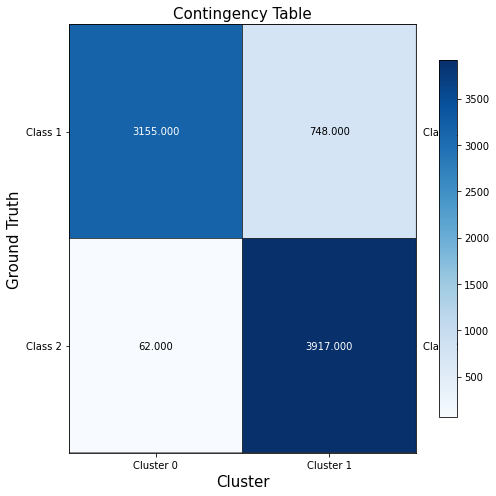

In [5]:
# K-means clustering with k = 2 using the TF-IDF data
k = 2
km = KMeans(n_clusters=k, random_state=0, max_iter=1000, n_init=30)
clusters = km.fit_predict(X_train_tfidf)

# Ground truth labels
ground_truth = [int(i/4) for i in newsgroups_data.target]

mat = contingency_matrix(ground_truth, clusters)

# Visualizing the matrix using plotmat.py
xlabels = ['Cluster 0', 'Cluster 1']
ylabels = ['Class 1', 'Class 2']
plotmat.plot_mat(mat, xticklabels=xlabels, yticklabels=ylabels, xlabel='Cluster', ylabel='Ground Truth', size=(7,7), title="Contingency Table")


### 2.2 Does the contingency matrix have to be square-shaped?

No, the contingency matrix does not have to be square shaped since the contingency matrix is a matrix where the rows represent the ground truth labels and the columns represent the predicted cluster labels, so therefore the contingency matrix can be rectangular shaped as well. However, in this scenario, since we only had 2 clusters and 2 ground truth labels, the contingency matrix was square-shaped.

## Question 3

### 3.1 Report the 5 clustering measures explained in the introduction for K-means clustering.

### 1. Homogeneity 
- is a measure of how “pure” the clusters are. If each cluster contains only data points from a single class, the homogeneity is satisfied.

In [6]:
h_score= homogeneity_score(ground_truth,clusters)
print("Homogeneity Score:", h_score)

Homogeneity Score: 0.568013245785168


### 2. Completeness 
- indicates how much of the data points of a class are assigned to the same cluster.

In [7]:
c_score = completeness_score(ground_truth,clusters)
print("Completeness:", c_score)

Completeness: 0.5822303423168675


### 3. V-measure
- is the harmonic average of homogeneity score and completeness score.

In [8]:
v_score = v_measure_score(ground_truth,clusters)
print("V-measure:", v_score)

V-measure: 0.5750339318643112


### 4. Adjusted Rand Index 
- is similar to accuracy, which computes similarity between the clustering labels and ground truth labels. This method counts all pairs of points that both fall either in the same cluster and the same class or in different clusters and different classes.

In [9]:
adj_ri = adjusted_rand_score(ground_truth,clusters)
print("Adjusted Rand Index:", adj_ri)

Adjusted Rand Index: 0.631133674855338


### 5. Adjusted Mutual Information Score 
- measures the mutual information between the cluster label distribution and the ground truth label distributions.

In [10]:
adj_mi = adjusted_mutual_info_score(ground_truth,clusters)
print("Adjusted Mutual Information Score:", adj_mi)

Adjusted Mutual Information Score: 0.5749945448304503


## Question 4

### 4.1 Report the plot of the percentage of variance that the top r principle components retain v.s. r, for r = 1 to 1000.

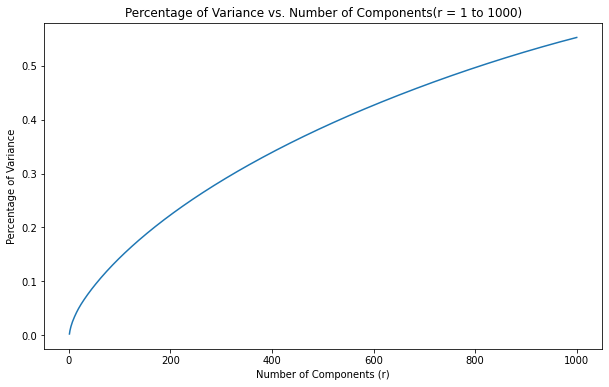

In [11]:
# Truncated SVD
r = 1000
svd = TruncatedSVD(n_components=r, random_state=0)
svd.fit_transform(X_train_tfidf)

# Cumulative explained variance ratio for each component
explained_variance = svd.explained_variance_ratio_.cumsum()

# R components
X_vals = np.array(range(1, r+1))

# Plot of the percentage of variance vs number of components
plt.figure(figsize=(10,6))
plt.plot(X_vals, explained_variance)
plt.title("Percentage of Variance vs. Number of Components(r = 1 to 1000)")
plt.xlabel("Number of Components (r)")
plt.ylabel("Percentage of Variance")
plt.show()

## Question 5

### 5.1 Let r be the dimension that we want to reduce the data to (i.e. n components). Try r = 1 − 10, 20, 50, 100, 300, and plot the 5 measure scores v.s. r for both SVD and NMF.

In [12]:
r_vals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]

# Metric scores for SVD
svd_h_score, svd_c_score, svd_v_score, svd_ajd_ri, svd_adj_mi = [], [], [], [], []

# Loops over the r values
for r in r_vals:
    # SVD
    svd = TruncatedSVD(n_components=r, random_state=0)
    X_train_svd = svd.fit_transform(X_train_tfidf)

    # K-Means
    km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
    svd_cluster = km.fit_predict(X_train_svd)

    # Clusters metric scores for SVD
    svd_h_score.append(homogeneity_score(ground_truth, svd_cluster))
    svd_c_score.append(completeness_score(ground_truth, svd_cluster))
    svd_v_score.append(v_measure_score(ground_truth, svd_cluster))
    svd_ajd_ri.append(adjusted_rand_score(ground_truth, svd_cluster))
    svd_adj_mi.append(adjusted_mutual_info_score(ground_truth, svd_cluster))

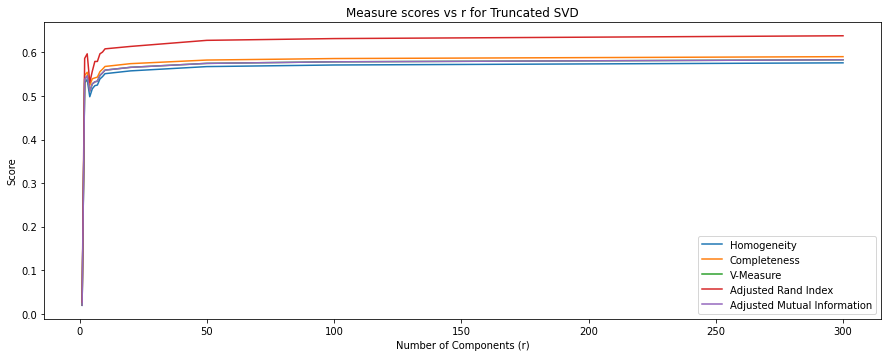

In [13]:
# Truncated SVD Plot
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.plot(r_vals, svd_h_score, label='Homogeneity')
plt.plot(r_vals, svd_c_score, label='Completeness')
plt.plot(r_vals, svd_v_score, label='V-Measure')
plt.plot(r_vals, svd_ajd_ri, label='Adjusted Rand Index')
plt.plot(r_vals, svd_adj_mi, label='Adjusted Mutual Information')
plt.xlabel("Number of Components (r)")
plt.ylabel("Score")
plt.title("Measure scores vs r for Truncated SVD")
plt.legend()

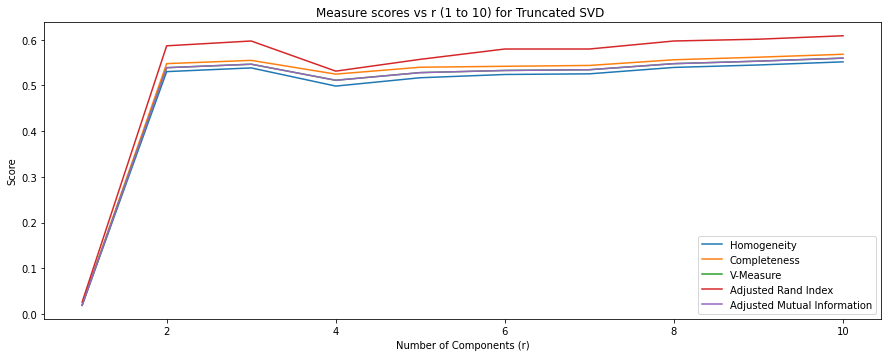

In [14]:
# Zoomed Truncated SVD plot (r = 1 to 10)
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.plot(r_vals[:10], svd_h_score[:10], label='Homogeneity')
plt.plot(r_vals[:10], svd_c_score[:10], label='Completeness')
plt.plot(r_vals[:10], svd_v_score[:10], label='V-Measure')
plt.plot(r_vals[:10], svd_ajd_ri[:10], label='Adjusted Rand Index')
plt.plot(r_vals[:10], svd_adj_mi[:10], label='Adjusted Mutual Information')
plt.xlabel("Number of Components (r)")
plt.ylabel("Score")
plt.title("Measure scores vs r (1 to 10) for Truncated SVD ")
plt.legend()

In [15]:
r_vals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]

# Metric scores for NMF
nmf_h_score, nmf_c_score, nmf_v_score, nmf_ajd_ri, nmf_adj_mi = [], [], [], [], []

# Loops over the r values
for r in r_vals:
    # NMF
    nmf = NMF(n_components=r, random_state=0, max_iter=2000)
    X_train_nmf = nmf.fit_transform(X_train_tfidf)

    # K-means
    km = KMeans(n_clusters=2, random_state=0, max_iter=1000, n_init=30)
    nmf_cluster = km.fit_predict(X_train_nmf)

    # Clusters metric scores for NMF
    nmf_h_score.append(homogeneity_score(ground_truth, nmf_cluster))
    nmf_c_score.append(completeness_score(ground_truth, nmf_cluster))
    nmf_v_score.append(v_measure_score(ground_truth, nmf_cluster))
    nmf_ajd_ri.append(adjusted_rand_score(ground_truth, nmf_cluster))
    nmf_adj_mi.append(adjusted_mutual_info_score(ground_truth, nmf_cluster))

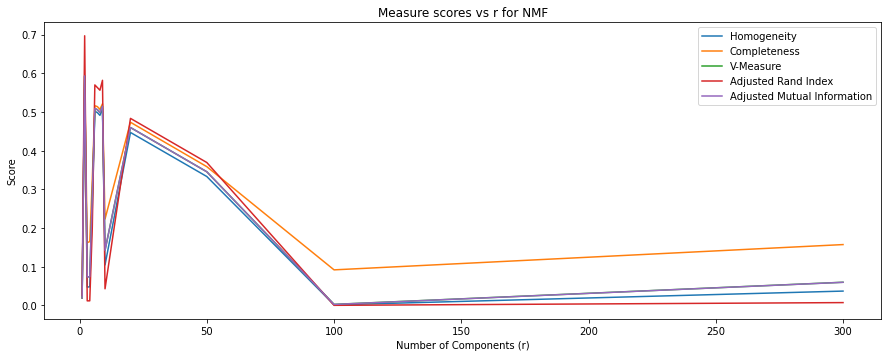

In [16]:
# NMF Plot
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.plot(r_vals, nmf_h_score, label='Homogeneity')
plt.plot(r_vals, nmf_c_score, label='Completeness')
plt.plot(r_vals, nmf_v_score, label='V-Measure')
plt.plot(r_vals, nmf_ajd_ri, label='Adjusted Rand Index')
plt.plot(r_vals, nmf_adj_mi, label='Adjusted Mutual Information')
plt.xlabel("Number of Components (r)")
plt.ylabel("Score")
plt.title("Measure scores vs r for NMF")
plt.legend()

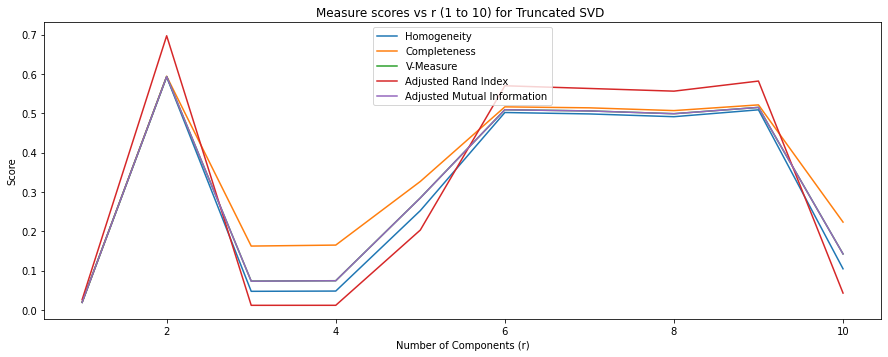

In [17]:
# Zoomed NMF plot (r = 1 to 10)
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
plt.plot(r_vals[:10], nmf_h_score[:10], label='Homogeneity')
plt.plot(r_vals[:10], nmf_c_score[:10], label='Completeness')
plt.plot(r_vals[:10], nmf_v_score[:10], label='V-Measure')
plt.plot(r_vals[:10], nmf_ajd_ri[:10], label='Adjusted Rand Index')
plt.plot(r_vals[:10], nmf_adj_mi[:10], label='Adjusted Mutual Information')
plt.xlabel("Number of Components (r)")
plt.ylabel("Score")
plt.title("Measure scores vs r (1 to 10) for Truncated SVD ")
plt.legend()

### 5.2 Report a good choice of r for SVD and NMF respectively.

The best rank for both SVD and NMF appears to be 2.

## Question 6

### 6.1 How do you explain the non-monotonic behavior of the measures as r increases?

## Question 7

### 7.1 Are these measures on average better than those computed in Question 3?

## Question 8

### 8.1 Visualize the clustering results for SVD with your optimal choice of r for K-Means clustering

### 8.2 Visualize the clustering results for NMF with your choice of r for K-Means clustering.

## Question 9

### 9.1 What do you observe in the visualization? How are the data points of the two classes distributed? Is distribution of the data ideal for K-Means clustering?

# Part 2 - Deep Learning and Clustering of Image Data

## Question 19

### 19.1 In a brief paragraph discuss: If the VGG network is trained on a dataset with perhaps totally different classes as targets, why would one expect the features derived from such a network to have discriminative power for a custom dataset?